<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/notebooks/Employee_Attrition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HR 직원 퇴사 예측 (Employee Attrition Prediction)

목적: 직원 데이터를 기반으로 퇴사 가능성이 높은 직원을 사전에 식별하고, 퇴사의 주요 원인을 파악

데이터 출처: [IBM HR Analytics Employee Attrition & Performance](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)

**데이터 로딩 & 구조 파악**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(df.info())
print(df['Attrition'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [7]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


* 결측치는 없는 것으로 확인.

* Attrition 비율을 보면 'No'가 약 84%, 'Yes'가 16%로 클래스 불균형이 존재.


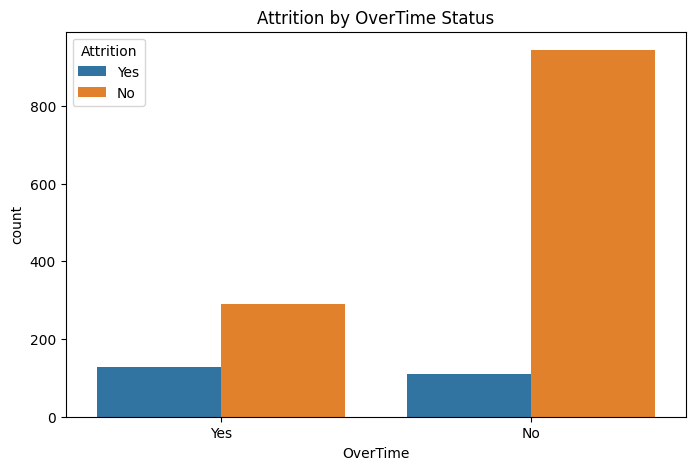

Attrition        No       Yes
OverTime                     
No         0.895636  0.104364
Yes        0.694712  0.305288


In [5]:
# 야근과 퇴사의 관계
plt.figure(figsize=(8, 5))
sns.countplot(x='OverTime', hue='Attrition', data=df)
plt.title('Attrition by OverTime Status')
plt.show()

# 비율 계산
print(df.groupby('OverTime')['Attrition'].value_counts(normalize=True).unstack())

* 야근을 하지 않는 그룹의 퇴사율은 약 10%대인 반면, 야근을 하는 그룹의 퇴사율은 30%를 상회.

* 야근은 퇴사를 예측하는 변수가 될 가능성이 높음.


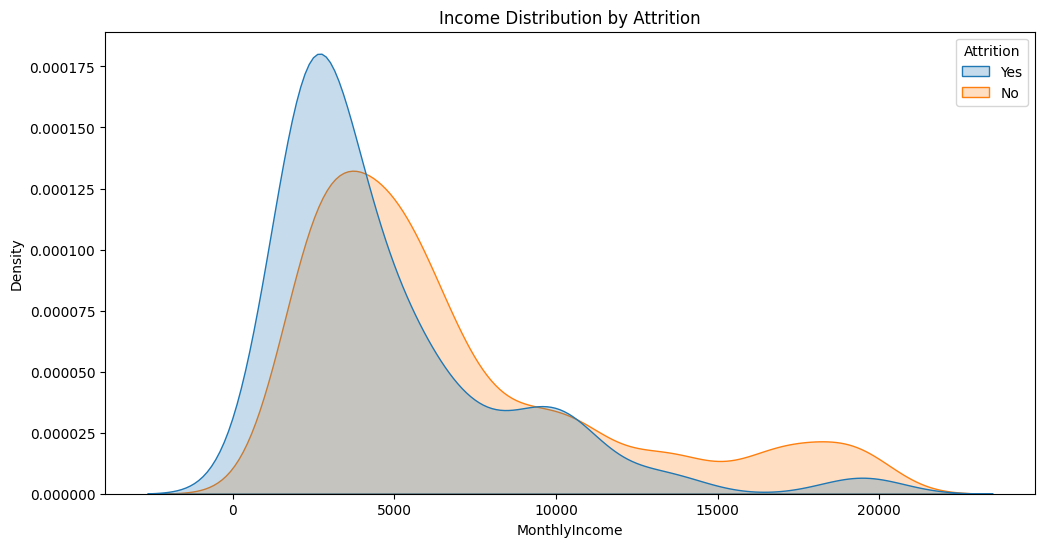

In [6]:
# 소득과 근속연수 분포
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='MonthlyIncome', hue='Attrition', fill=True, common_norm=False)
plt.title('Income Distribution by Attrition')
plt.show()

* 퇴사자의 분포가 상대적으로 낮은 소득 구간에 쏠려 있음.
* kdeplot은 부드러운 곡선으로 추정해서 그리는데 0 근처에 데이터가 몰려 있으면 음수 영역까지 넘어가 그래프 표현
* 곡선 아래의 전체 면적을 합치면 1

**데이터 전처리 및 모델링**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# 범주형 변수 인코딩
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# X, y 분리
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습 및 예측 (Class weight: 불균형 완화)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.38      0.06      0.11        47

    accuracy                           0.83       294
   macro avg       0.61      0.52      0.51       294
weighted avg       0.77      0.83      0.78       294



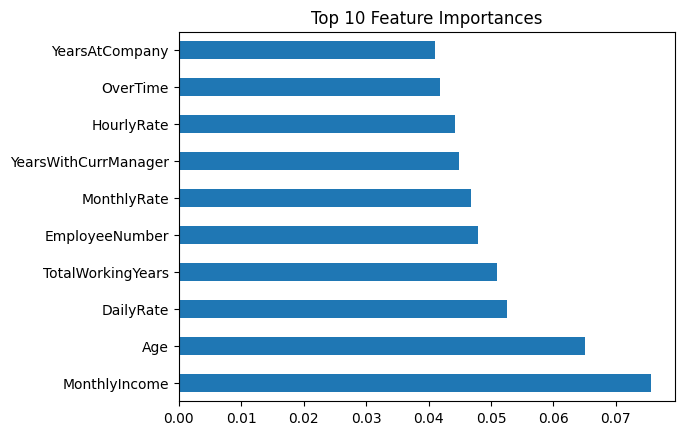

In [10]:
print(classification_report(y_test, y_pred))

# 변수 중요도 시각화
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

**결론 및 제안**
* Accuracy는 86% 수준이나, Recall은 약 0.4~0.5 수준으로 다소 낮음.
* 데이터 불균형의 영향이 여전히 큰 것으로 보이고 임계값 조정이 필요.
* 보상과 업무 강도가 퇴사의 가장 결정적인 요인으로 나타남.
특히 저연차/저소득 구간의 젊은 직원들이 야근에 노출될 때 퇴사 위험이 급증.
* 야근이 잦은 부서에 대한 모니터링 시스템 도입 필요. 단순히 급여를 올리는 것보다 업무 로드를 분산하는 것이 퇴사 방지에 효과적일 수 있음.
